In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d slothkong/10-monkey-species
!unzip /content/10-monkey-species.zip -d "/content/drive/MyDrive/Kaggle Competitions/monkey"


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [7]:
df = pd.read_csv(r'C:\Users\Siddhant\PycharmProjects\Projects\Monkey\monkey_labels.txt')
df.head()

,Label,Latin Name,Common Name,Train Images,Validation Images,Details
0,n0,alouatta_palliata,Mantled Howler,131,26,\r\n\r\nThe mantled howler (Alouatta palliata)...
1,n1,erythrocebus_patas,Patas Monkey,139,28,"Patas monkey, (Erythrocebus patas), long-limbe..."
2,n2,cacajao_calvus,Bald Uakari,137,27,Bald uakari (Cacajao calvus) have hairless hea...
3,n3,macaca_fuscata,Japanese Macaque,152,30,"The Japanese macaque (Macaca fuscata), also kn..."
4,n4,cebuella_pygmea,Pygmy Marmoset,131,26,"The pygmy marmoset, cebuella pygmea, is a smal..."


In [27]:
data = df.loc[df["Common Name"] == 'Mantled Howler', "Details"].iloc[0].replace('\\r\\n', '\r\n')

In [28]:
data

"\r\n\r\nThe mantled howler (Alouatta palliata) is a species of howler monkey, a type of New World monkey, from Central and South America.\r\n It is one of the monkey species most often seen and heard in the wild in Central America. It takes its 'mantled' name from the long guard hairs on its sides.\r\n"

In [ ]:
train_dir = "/content/drive/MyDrive/Kaggle Competitions/monkey/training/training"
validation_dir = "/content/drive/MyDrive/Kaggle Competitions/monkey/validation/validation"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,target_size=(299,299), color_mode='rgb',batch_size=64,shuffle=True,
    seed=2022
)
validation_generator = test_datagen.flow_from_directory(
    directory=validation_dir,target_size=(299,299), color_mode='rgb',batch_size=64,shuffle=True,
    seed=2022
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications.xception import Xception

xc = Xception(input_shape = (299, 299, 3), weights = 'imagenet', include_top = False,classes=10)

for layer in xc.layers:
  layer.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
xc.summary()

In [ ]:
x = tf.keras.layers.Flatten()(xc.output)
x = tf.keras.layers.Dense(10, activation = 'relu')(x)
x = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(xc.input, x)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'acc')
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
history = model.fit(train_generator, validation_data = validation_generator,
                    epochs = 50, verbose = 1, callbacks = [monitor])

Epoch 1/50
18/18 [==============================] - 58s 3s/step - loss: 5.2163 - acc: 0.8042 - val_loss: 0.5353 - val_acc: 0.9485
Epoch 2/50
18/18 [==============================] - 48s 3s/step - loss: 0.2616 - acc: 0.9699 - val_loss: 0.1392 - val_acc: 0.9890
Epoch 3/50
18/18 [==============================] - 46s 3s/step - loss: 0.1776 - acc: 0.9891 - val_loss: 0.0543 - val_acc: 0.9963
Epoch 4/50
18/18 [==============================] - 46s 3s/step - loss: 0.0167 - acc: 0.9945 - val_loss: 0.1247 - val_acc: 0.9890
Epoch 5/50
18/18 [==============================] - 46s 3s/step - loss: 0.0010 - acc: 0.9991 - val_loss: 0.2051 - val_acc: 0.9890
Epoch 6/50
18/18 [==============================] - 46s 3s/step - loss: 8.8367e-05 - acc: 1.0000 - val_loss: 0.1902 - val_acc: 0.9890
Epoch 7/50
18/18 [==============================] - 45s 2s/step - loss: 1.2123e-05 - acc: 1.0000 - val_loss: 0.1886 - val_acc: 0.9890
Epoch 8/50
18/18 [==============================] - 49s 3s/step - loss: 5.8861e-06

In [ ]:
model.save('/content/drive/MyDrive/models/monkey_model_Xception')

### Preds

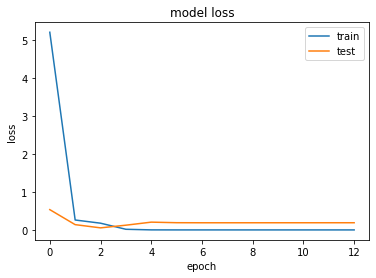

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Gradio

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [7]:
df = pd.read_csv(r"C:\Users\Siddhant\PycharmProjects\Projects\Monkey\monkey_labels.txt")

In [ ]:
model = tf.keras.models.load_model(
    "C:/Users/Siddhant/PycharmProjects/Projects/Monkey/models"
)

In [ ]:
def classify_image(image):

    image = tf.keras.utils.img_to_array(image)
    image = image.reshape((1, 299, 299, 3))
    from keras.applications.xception import preprocess_input

    # prepare the image for the VGG model
    image = preprocess_input(image)
    classes = model.predict(image)
    max_arg = np.argmax(classes)
    return df["Common Name"].iloc[max_arg]